In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2 as cv
import kornia as kn
from math import log
from plot_inlier_matches import *

### A3 Part B: Glendon Hall stitching

In [2]:
def SIFT_detect_prune(src_img: np.ndarray, dest_img: np.ndarray, top_p: float,
                      src_mask_line: float = 0., dest_mask_line: float = 1., src_left_dest_right=True) -> tuple:
    '''
    src_img, dest_img: grayscale pictures
    src_mask_line: approx non-related column portion of src_img starting from its LEFT, [0.~1.]
    dest_mask_line: approx non-related column portion of dest_img starting from its LEFT, [0.~1.]
    src_left_dest_right: default interprete src_mask_line & dest_mask_line as left->right direction, affects mask direction
        i.e. src_img tries to match from left of dest_img
    top_p: choosing top percentage of least distance descriptor points, (0.~1.]
    return: top src->dest SIFT matche points
    '''
    # Detect SIFT keypoints and extract descriptors from source and destination images
    src_mask = np.zeros(src_img.shape, dtype=np.uint8)
    dest_mask = np.zeros(dest_img.shape, dtype=np.uint8)
    src_mask[:, int(src_img.shape[1] * src_mask_line):] = 255
    dest_mask[:, :int(dest_img.shape[1] * dest_mask_line)] = 255
    
    if not src_left_dest_right:
        src_mask = np.full(src_img.shape, 255, dtype=np.uint8) - src_mask
        dest_mask = np.full(dest_img.shape, 255, dtype=np.uint8) - dest_mask

    sift = cv.SIFT_create()
    src_kp, src_desc = sift.detectAndCompute(src_img, src_mask)
    dest_kp, dest_desc = sift.detectAndCompute(dest_img, dest_mask)
    print(f"Total keypoints found in source & dest images: {len(src_kp)}, {len(dest_kp)}")

    # random pick 1/2 rows to reduce memory use. getting 100k+ keypoints after mask
    src_choice = np.random.choice(len(src_kp), len(src_kp)//2, replace=True)
    dest_choice = np.random.choice(len(dest_kp), len(dest_kp)//2, replace=True)
    print(f"Reduce keypoints to random 1/2: {len(src_kp)//2}, {len(dest_kp)//2}")
    
    src_kpt = torch.tensor([kp.pt for kp in src_kp])[src_choice]
    dest_kpt = torch.tensor([kp.pt for kp in dest_kp])[dest_choice]
    src_desc_t = torch.tensor(src_desc)[src_choice]
    dest_desc_t = torch.tensor(dest_desc)[dest_choice]

    # Match features between left->mid and right->mid image
    distance, matches = kn.feature.match_snn(src_desc_t, dest_desc_t)
    print(f"Total matches source->dest: {distance.shape[0]}\n")

    sort_index = distance.argsort(dim=0).squeeze()
    top = sort_index[:int(len(sort_index)*top_p)]
    matches_new = matches[top,]

    return src_kpt[matches_new[:, 0]], dest_kpt[matches_new[:, 1]]

In [3]:
def get_homography(src: torch.Tensor, des: torch.Tensor) -> torch.Tensor:
    """
    src: tensor of M source points, (M, 2)
    des: tensor of M target points, (M, 2)
    return: estimate tensor of homography matrix from source to target, (3, 3)
    """
    M, _ = src.shape
    homog = torch.cat((src, torch.ones(M,1)), dim=-1)
    front = torch.cat((homog, torch.zeros(M,3)), dim=-1)
    mid = torch.cat((torch.zeros(M,3), homog), dim=-1)
    A6 = torch.stack((front, mid), dim=-2).view(2*M,6)
    
    homo2 = torch.stack((homog, homog), dim=-2).view(2*M, 3)
    b = des.view(2*M,1)
    rear = homo2 * (-b)
    
    A = torch.cat((A6, rear), dim=1).numpy()
    _, _, Vh = np.linalg.svd(A)
    return torch.tensor(Vh[-1]).view(3,3)

In [4]:
# test get_homography function for 4 random pairs of points
M = 4
print(f"{M} pairs of points")
src = torch.from_numpy(np.random.choice(100, (M,2), replace=False)).float()
print(f"source points:\n{src}")
des = torch.from_numpy(np.random.choice(100, (M,2), replace=False)).float()
print(f"destination points:\n{des}")
H = get_homography(src, des)
print(f"result homography matrix:\n{H}")

src_h = torch.cat((src, torch.ones(M,1)), dim=-1)
des_h = torch.cat((des, torch.ones(M,1)), dim=-1)
res = src_h @ H.T
res_z = res[:, :2] / res[:, -1:]
print(f"H transform result points:\n{res_z}")

des1 = des.clone()
print('\ndes x shift +5, y shift +2')
des1 += torch.tensor([5, 2])
print(des1)
hh = get_homography(src, des1)
print(f"new result homography matrix:\n{hh}")
trans = torch.tensor([[1,0,5], [0,1,2], [0,0,1]]).float()
print(f"translation affine A:\n{trans}")
cal_AH = trans @ H
print(f"trans after homo, A @ H:\n{cal_AH}")
hh_new = torch.mean(cal_AH[-1,] / hh[-1,]) * hh
print(f"new result homography align with A @ H:\n{hh_new}")

4 pairs of points
source points:
tensor([[94.,  0.],
        [50., 92.],
        [22., 82.],
        [58., 63.]])
destination points:
tensor([[60., 86.],
        [32., 13.],
        [ 7., 91.],
        [25., 66.]])
result homography matrix:
tensor([[-6.3780e-05,  2.7058e-04, -4.6881e-02],
        [ 9.8192e-03,  5.4088e-03, -9.9879e-01],
        [ 8.9408e-05,  4.3787e-05, -9.2856e-03]])
H transform result points:
tensor([[60.0000, 85.9999],
        [32.0000, 13.0000],
        [ 7.0000, 91.0000],
        [25.0000, 66.0000]])

des x shift +5, y shift +2
tensor([[65., 88.],
        [37., 15.],
        [12., 93.],
        [30., 68.]])
new result homography matrix:
tensor([[ 3.7510e-04,  4.7910e-04, -9.1323e-02],
        [ 9.7853e-03,  5.3794e-03, -9.9572e-01],
        [ 8.7505e-05,  4.2856e-05, -9.0880e-03]])
translation affine A:
tensor([[1., 0., 5.],
        [0., 1., 2.],
        [0., 0., 1.]])
trans after homo, A @ H:
tensor([[ 3.8326e-04,  4.8951e-04, -9.3309e-02],
        [ 9.9980e-03,

In [5]:
def RANSAC_homography(src_pts: torch.Tensor, des_pts: torch.Tensor, outlier_p: float, threshold: float) -> torch.Tensor:
    pool_N = src_pts.shape[0]
    # p: desired probability of at least 1 good sample
    # s: number of points (pair) in a sample, 4
    # outlier_p: proportion of outliers, estimate 0.4-0.6
    p = 0.99
    s = 4

    # N: RANSAC iterations
    N = int(log(1-p) / log(1-(1-outlier_p)**s))
    print(f"Total RANSAC iterations: {N}")

    # threshold: float, destination's pixel radius of acceptable mapping
    th2 = threshold ** 2
    n = N
    inliers, inliers_des = None, None
    max_n, inlier_n = 0, 0

    while n > 0 and max_n < pool_N:
        # random choose 3 point pairs from source and destination, find affine matrix
        choices = np.random.choice(pool_N, (4,), replace=False)
        H = get_homography(src_pts[choices], des_pts[choices])
        # transform all source points towards destination, check distance threshold
        src_homo = torch.cat((src_pts, torch.ones(pool_N,1)), dim=-1)
        res = src_homo @ H.T
        res_z = res[:, :2] / res[:, -1:]
        distance = torch.sum(torch.square(res_z - des_pts), dim=1)
        inlier_bool = distance < th2
        inlier_n = torch.sum(inlier_bool).item()
        if inlier_n > max_n:
            max_n = inlier_n
            inliers = src_pts[inlier_bool]
            inliers_des = des_pts[inlier_bool]
        n -= 1

    print(f"Actual RANSAC iterations: {N-n}")
    print(f"RANSAC found {max_n} inliers from samples {pool_N}\n")
    return inliers, inliers_des

In [6]:
def adapt_corners(H: torch.Tensor, h: int, w: int) -> tuple:
    '''
    H: homography tensor (1, 3, 3)
    h: source image height
    w: source image width
    return: modified homography, translation affine matrix
    '''
    # find offset of new corners of a image with h:w after Homography
    corner = torch.tensor([[0, 0, 1], [h, 0, 1], [h, w, 1], [0, w, 1]]).float()
    res = corner @ H.squeeze().T
    res_z = res[:, :2] / res[:, -1:]

    # find abs(negative offset) of transformed corners from origin
    minxy = torch.min(res_z, dim=0)[0]
    minxy_adapt = torch.where(minxy < 0, torch.abs(minxy), 0).int()

    # find offset of transformed corners from image boundary
    maxxy = torch.max(res_z, dim=0)[0]
    bound = torch.tensor([h, w]).float()
    maxxy_adapt = torch.where(maxxy > bound, maxxy-bound, 0).int()

    # find new homography matrix condisering minxy
    aff = torch.tensor([[1, 0, minxy_adapt[0]], [0, 1, minxy_adapt[1]], [0, 0, 1]]).float()

    return aff, minxy_adapt, maxxy_adapt

In [7]:
def panorama3(left:np.ndarray, mid:np.ndarray, right:np.ndarray, H1:torch.tensor, H2:torch.tensor) -> torch.tensor:
    le = cv.cvtColor(left, cv.COLOR_BGR2RGB)
    mi = cv.cvtColor(mid, cv.COLOR_BGR2RGB)
    ri = cv.cvtColor(right, cv.COLOR_BGR2RGB)
    aug_left, aug_mid = le.copy(), mi.copy()

    # augment images to the same size for later
    l1, l2, _ = le.shape
    m1, m2, _ = mi.shape
    h, w = max(l1, m1), max(l2, m2)
    if l1 < h or l2 < w:
        aug_left = np.zeros((h, w, 3), dtype=np.uint8)
        aug_left[:l1, :l2, :] = le
    if m1 < h or m2 < w:
        aug_mid = np.zeros((h, w, 3), dtype=np.uint8)
        aug_mid[:m1, :m2, :] = mi
    img_left = kn.utils.image_to_tensor(aug_left, keepdim=False).float()/255.
    img_mid = kn.utils.image_to_tensor(aug_mid, keepdim=False).float()/255.

    # blend left-mid images
    aff1, minxy, _ = adapt_corners(H1, l1, l2)
    AH1 = aff1 @ H1
    x1, y1 = minxy

    l_pad = kn.geometry.transform.warp_perspective(img_left, AH1.unsqueeze(0), (h+y1, w+x1))
    m_pad = torch.zeros(1, 3, h+y1, w+x1)
    m_pad[..., y1:, x1:] = img_mid
    blend_lm = torch.max(l_pad, m_pad)

    # blend left-mid-right images
    r1, r2, _ = ri.shape
    h1, w1 = blend_lm.shape[-2:]
    img_right=kn.utils.image_to_tensor(ri, keepdim=False).float()/255.

    aff2, minxy2, maxxy = adapt_corners(H2, r1, r2)
    AH2 = aff2 @ aff1 @ H2
    x11, y11 = minxy2
    x2, y2 = maxxy
    right_warp = kn.geometry.transform.warp_perspective(img_right, AH2.unsqueeze(0), (h1+y11+y2, w1+x11+x2))

    lm_pad = torch.zeros(1, 3, h1+y11+y2, w1+x11+x2)
    lm_pad[..., min(y11,y1):h1+min(y11,y1), x11:w1+x11] = blend_lm
    return torch.max(lm_pad, right_warp)

### Glendon Hall

In [8]:
# Gendon Hall stitching, use h/2:w/2 images for a bit less run time
glendon_left = cv.imread("Glendon-Hall-left1.jpg")
glendon_mid = cv.imread("Glendon-Hall-middle1.jpg")
glendon_right = cv.imread("Glendon-Hall-right1.jpg")

# prepare grayscale for SIFT
g_left = cv.cvtColor(glendon_left, cv.COLOR_BGR2GRAY)
g_mid = cv.cvtColor(glendon_mid, cv.COLOR_BGR2GRAY)
g_right = cv.cvtColor(glendon_right, cv.COLOR_BGR2GRAY)

# Get SIFT detected keypoints and prune by least descriptor distances
left_kp, left_mid_kp = SIFT_detect_prune(g_left, g_mid, top_p=1., src_mask_line=0.5, dest_mask_line=0.5)
right_kp, right_mid_kp = SIFT_detect_prune(g_right, g_mid, top_p=1., src_mask_line=0.66, dest_mask_line=0.33, src_left_dest_right=False)

Total keypoints found in source & dest images: 29756, 32737
Reduce keypoints to random 1/2: 14878, 16368
Total matches source->dest: 1369

Total keypoints found in source & dest images: 25238, 27678
Reduce keypoints to random 1/2: 12619, 13839
Total matches source->dest: 1760



In [9]:
# Run RANSAC and find best homography of left->mid, right->mid
print("RANSAC on left-mid image homography...")
inlier_l, inlier_lm = RANSAC_homography(left_kp, left_mid_kp, outlier_p=0.8, threshold=0.7)
H1 = get_homography(inlier_l, inlier_lm)

print("RANSAC on right-mid image homography...")
inlier_r, inlier_rm = RANSAC_homography(right_kp, right_mid_kp, outlier_p=0.8, threshold=0.7)
H2 = get_homography(inlier_r, inlier_rm)

RANSAC on left-mid image homography...
Total RANSAC iterations: 2875
Actual RANSAC iterations: 2875
RANSAC found 376 inliers from samples 1369

RANSAC on right-mid image homography...
Total RANSAC iterations: 2875
Actual RANSAC iterations: 2875
RANSAC found 517 inliers from samples 1760



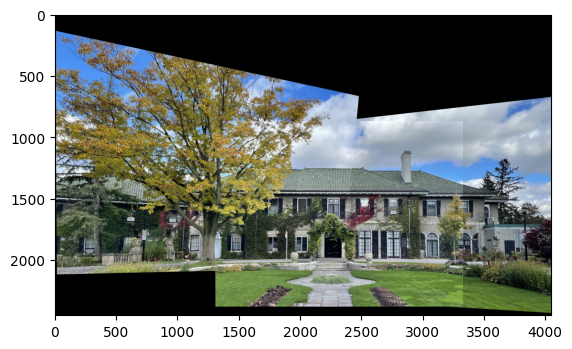

In [10]:
blend = panorama3(glendon_left, glendon_mid, glendon_right, H1, H2)
plt.imshow(kn.utils.tensor_to_image(blend))